In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

In [3]:
# train and test are splitted by time
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Описание данных

In [4]:
train_df.head()

,city_56_cat_distribution_ekb,city_56_cat_distribution_kazan,city_56_cat_distribution_kransnodar,city_56_cat_distribution_moscow,city_56_cat_distribution_others,city_56_cat_distribution_spb,discount_value_56_sum,duration_sec_56_sum_with_orders,duration_sec_56_sum_wo_orders,is_control,...,session_part_of_local_day_56_cat_distribution_21-24,session_part_of_local_day_56_cat_distribution_3-6,session_part_of_local_day_56_cat_distribution_6-9,session_part_of_local_day_56_cat_distribution_9-12,session_with_offer_56_conversion_rate,success_orders_56_cnt,travel_distance_km_56_sum,travel_time_min_56_sum,exp_discount_value,exp_n_trips
0,0.0,0.0,0.0,0.866667,0.133333,0.0,112.0,10141,9369,True,...,0.202381,0.000000,0.035714,0.095238,0.400000,30,214.623,479.35,0.000000,5.526326
1,0.0,0.0,0.0,0.000000,1.000000,0.0,57.0,938,19152,False,...,0.326923,0.019231,0.057692,0.000000,0.347826,16,156.276,265.90,10.252258,1.230271
2,0.0,0.0,0.0,0.944444,0.055556,0.0,12.0,7176,6947,False,...,0.126437,0.011494,0.034483,0.229885,0.507042,36,195.984,377.00,0.000000,1.000503
3,0.0,0.0,0.0,0.939394,0.060606,0.0,86.0,7054,6011,False,...,0.103896,0.012987,0.025974,0.207792,0.540984,33,174.685,345.10,0.000000,0.410090
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000,0.00,0.000000,0.000000


Фичи, которые относятся к эксперименту и **не должны** быть использованы как признаки модели:   
exp_discount_value - сумма скидок, которую получил пользователь во время экперимента   
exp_n_trips - число поездок, которые совершил пользовать во время экперимента  

is_control - был ли человек в контрольной группе во время эксперимента (в некоторых случаях можно использовать как признак) 

Дальше идут фичи, которые **можно** использовать как признаки модели.  
Все фичи пользователей посчитаны за последние 56 дней перед проведением теста.

**Категориальные фичи**, которые переведены в пропорции от 0 до 1 по категориям:    
city_56_cat_distribution_* - город cовершения заказа  
session_local_weekday_56_cat_distribution_* - сессия: день недели    
session_local_weekend_56_cat_distribution_* - сессия: рабочий / выходной день  
session_part_of_local_day_56_cat_distribution_* - сессия: часть дня в разбивке по 3 часа  
order_local_weekday_56_cat_distribution_* - заказ: день недели    
order_local_weekend_56_cat_distribution_* - заказ: рабочий / выходной день  
order_part_of_local_day_56_cat_distribution_* - заказ: часть дня в разбивке по 3 часа  


**Числовые фичи:**  
discount_value_56_sum - сумма скидок  
duration_sec_56_sum_with_orders - сумма длительности сессий пользователя, когда он в итоге сделал заказ  
duration_sec_56_sum_wo_orders - сумма длительности сессий пользователя, когда он заказ не сделал
last_absent_days - сколько дней пользователь не совершал заказов  
last_absent_days_wo_sessions - сколько дней пользователь не заходил в приложение  
missed_days_orders_56_mean - интервал между заказами в днях  
missed_days_sessions_56_mean - интервал между сессиями в днях
offer_cnt_56_conversion_rate - конверсия из оффера в заказ  
offer_cnt_56_sum_with_orders - сумма офферов с заказами  
offer_cnt_56_sum_wo_orders - сумма офферов без заказа  
order_cost_rur_56_sum - сумма стоимости всех заказов  
session_with_offer_56_conversion_rate - конверсия из сессии в заказ  
success_orders_56_cnt - число всех заказов  
travel_distance_km_56_sum - расстояние по всем заказам  
travel_time_min_56_sum - длительность по всем заказам  

### Пример

В качестве модели в Uplift моделировании может быть любая функция, которая позволяет ранжировать пользователей.  
Я решил использовать одну из фичей: количество поездок за 56 дней в качестве скора.

In [5]:
train_preds = -train_df.success_orders_56_cnt.values
test_preds = -test_df.success_orders_56_cnt.values

In [6]:
train_metric_df = pd.DataFrame({
    'Model': train_preds,
    'w': ~train_df.is_control.values,
    'y': train_df.exp_n_trips
})

test_metric_df = pd.DataFrame({
    'Model': test_preds,
    'w': ~test_df.is_control.values,
    'y': test_df.exp_n_trips
})

### Валидация

Теперь посмотрим на то, что у нас получилось.  
Основная метрика, которая интересует бизнес - это стомость доп трипа (COT):
$$COT = {\overline{discount_{test}} - \overline{disount_{control}} \over \overline{trips_{test}} - \overline{trips_{control}}} $$
Я немного переделал код из casualml, чтобы можно было посчитать эту метрику.  
Идея такая же - можем посмотреть на график и отдельно на AUUC.

In [7]:
from utils import CostMetrics

In [8]:
cost = CostMetrics(pd.DataFrame({
    'Model': test_preds,
    'w': ~test_df.is_control.values,
    'exp_n_trips': test_df.exp_n_trips,
    'exp_discount_value': test_df.exp_discount_value
}))

Model      98.662298
Random    174.159396
dtype: float64

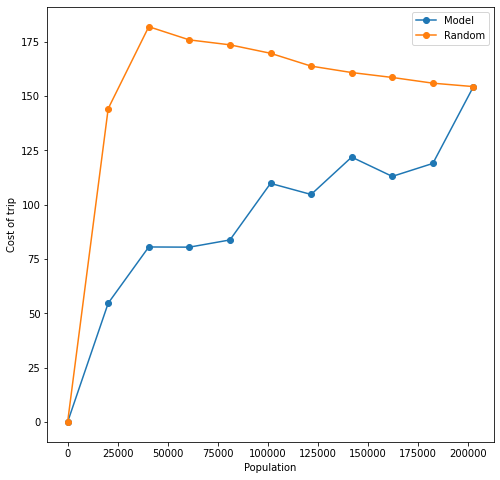

In [9]:
cost.get_cumlift()
cost.plot()
cost.auuc_score()

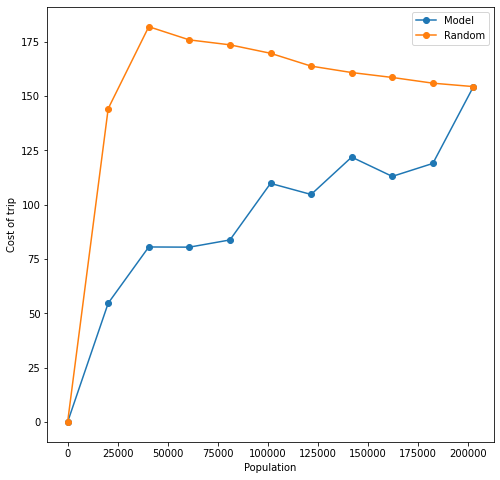

In [10]:
cost.plot()

In [11]:
cost.auuc_score()

Model      98.662298
Random    174.159396
dtype: float64

### Задание 1

Используйте метод трансформации таргета, чтобы показать результат не хуже, чем у такого простого решения, как ранжирование по одной фиче.  
В качестве таргета используйте exp_n_trips.  
Не забывайте про необходимость посмотреть на данные, почистить их и так далее.

### Посмотрим на данные более внимательно.

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [13]:
train_df

,city_56_cat_distribution_ekb,city_56_cat_distribution_kazan,city_56_cat_distribution_kransnodar,city_56_cat_distribution_moscow,city_56_cat_distribution_others,city_56_cat_distribution_spb,discount_value_56_sum,duration_sec_56_sum_with_orders,duration_sec_56_sum_wo_orders,is_control,...,session_part_of_local_day_56_cat_distribution_21-24,session_part_of_local_day_56_cat_distribution_3-6,session_part_of_local_day_56_cat_distribution_6-9,session_part_of_local_day_56_cat_distribution_9-12,session_with_offer_56_conversion_rate,success_orders_56_cnt,travel_distance_km_56_sum,travel_time_min_56_sum,exp_discount_value,exp_n_trips
0,0.0,0.0,0.00,0.866667,0.133333,0.000000,112.0,10141,9369,True,...,0.202381,0.000000,0.035714,0.095238,0.400000,30,214.623,479.350000,0.000000,5.526326
1,0.0,0.0,0.00,0.000000,1.000000,0.000000,57.0,938,19152,False,...,0.326923,0.019231,0.057692,0.000000,0.347826,16,156.276,265.900000,10.252258,1.230271
2,0.0,0.0,0.00,0.944444,0.055556,0.000000,12.0,7176,6947,False,...,0.126437,0.011494,0.034483,0.229885,0.507042,36,195.984,377.000000,0.000000,1.000503
3,0.0,0.0,0.00,0.939394,0.060606,0.000000,86.0,7054,6011,False,...,0.103896,0.012987,0.025974,0.207792,0.540984,33,174.685,345.100000,0.000000,0.410090
4,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0,0,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690574,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0,0,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000,0.000000,0.000000,0.000000
690575,0.0,0.0,0.00,0.000000,0.333333,0.666667,0.0,3141,176,False,...,0.000000,0.000000,0.125000,0.250000,0.500000,3,77.797,139.566667,0.000000,0.000000
690576,0.0,0.0,0.00,0.500000,0.500000,0.000000,0.0,2746,44,False,...,0.142857,0.000000,0.000000,0.000000,0.285714,2,16.008,26.600000,15.654860,0.579810
690577,0.0,0.0,0.00,0.000000,0.000000,1.000000,54.0,2245,1923,True,...,0.142857,0.047619,0.190476,0.190476,0.450000,9,56.613,155.416667,0.000000,1.168465


In [14]:
train_df.exp_n_trips

0         5.526326
1         1.230271
2         1.000503
3         0.410090
4         0.000000
            ...   
690574    0.000000
690575    0.000000
690576    0.579810
690577    1.168465
690578    0.000000
Name: exp_n_trips, Length: 690579, dtype: float64

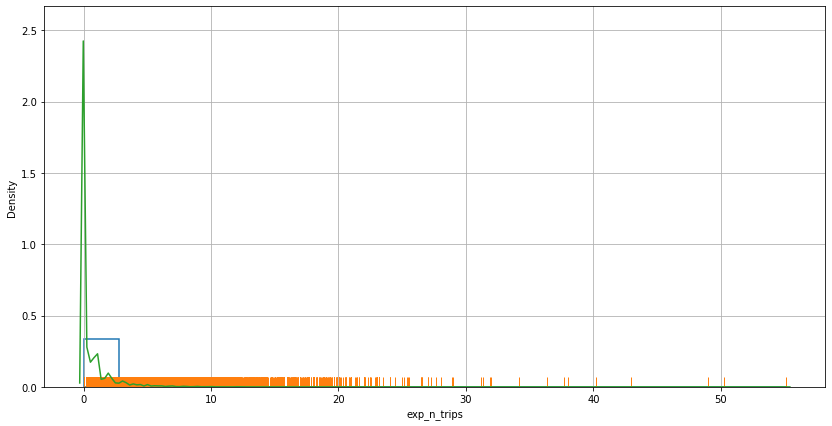

In [15]:
# Задаем размер рисунка:
f, ax = plt.subplots(figsize=(14, 7))
plt.grid()
x = 'exp_n_trips'
# рисуем гистограмму:
sns.histplot(x=x,
             stat="density",
             bins=20,
             fill=False,
             data=train_df);

# отмечаем каждую точку наблюдений:
sns.rugplot(x=x,
            data=train_df);


# и, наконец, плотность ядра:
sns.kdeplot(x=x,
            data=train_df);

Как видим целевая переменная сконцентрирована около 0, поэтому давайте посмотрим на распределение всех короме нулевых.

In [16]:
without_zero_train_df = train_df[train_df.exp_n_trips > 0]

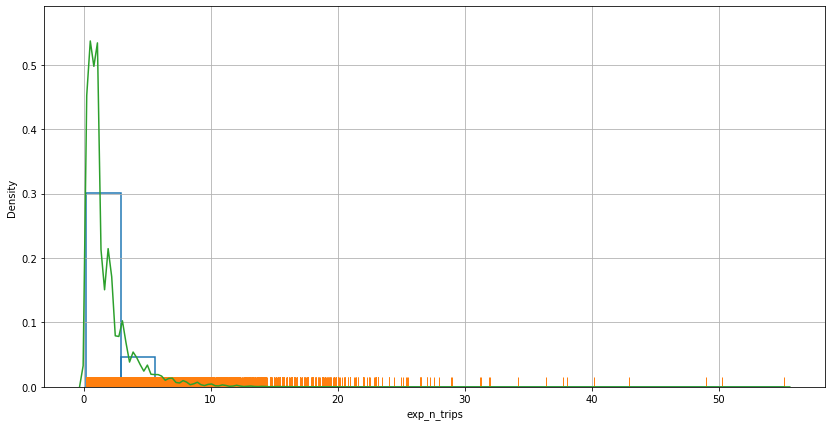

In [17]:
# Задаем размер рисунка:
f, ax = plt.subplots(figsize=(14, 7))
plt.grid()
x = 'exp_n_trips'
# рисуем гистограмму:
sns.histplot(x=x,
             stat="density",
             bins=20,
             fill=False,
             data=without_zero_train_df);

# отмечаем каждую точку наблюдений:
sns.rugplot(x=x,
            data=without_zero_train_df);


# и, наконец, плотность ядра:
sns.kdeplot(x=x,
            data=without_zero_train_df);

Заметим, что у нас есть пространство высокой плотности (где-то ``[0, 15]``), а после 15 у нас не так много , логично воспринять это как шум (не выброс!)

In [18]:
new_train_df = without_zero_train_df[without_zero_train_df.exp_n_trips < 15]

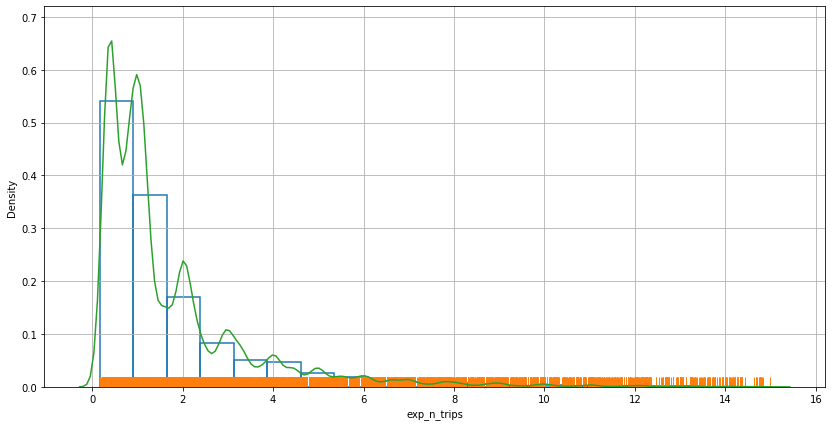

In [19]:
# Задаем размер рисунка:
f, ax = plt.subplots(figsize=(14, 7))
plt.grid()
x = 'exp_n_trips'
# рисуем гистограмму:
sns.histplot(x=x,
             stat="density",
             bins=20,
             fill=False,
             data=new_train_df);

# отмечаем каждую точку наблюдений:
sns.rugplot(x=x,
            data=new_train_df);


# и, наконец, плотность ядра:
sns.kdeplot(x=x,
            data=new_train_df);

Уменьшив масштаб, можно заметить, что вес хвостов небольшой, поэтому оставим только до 5.

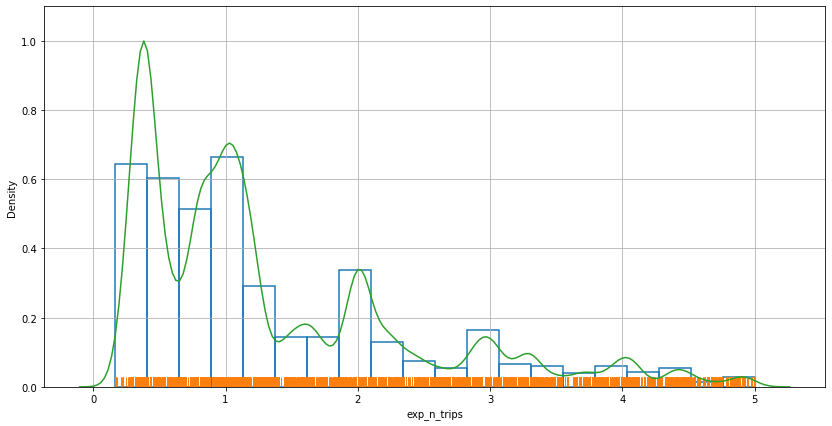

In [20]:
new_train_df = without_zero_train_df[without_zero_train_df.exp_n_trips < 5]

# Задаем размер рисунка:
f, ax = plt.subplots(figsize=(14, 7))
plt.grid()
x = 'exp_n_trips'
# рисуем гистограмму:
sns.histplot(x=x,
             stat="density",
             bins=20,
             fill=False,
             data=new_train_df);

# отмечаем каждую точку наблюдений:
sns.rugplot(x=x,
            data=new_train_df);


# и, наконец, плотность ядра:
sns.kdeplot(x=x,
            data=new_train_df);

In [21]:
new_train_df

,city_56_cat_distribution_ekb,city_56_cat_distribution_kazan,city_56_cat_distribution_kransnodar,city_56_cat_distribution_moscow,city_56_cat_distribution_others,city_56_cat_distribution_spb,discount_value_56_sum,duration_sec_56_sum_with_orders,duration_sec_56_sum_wo_orders,is_control,...,session_part_of_local_day_56_cat_distribution_21-24,session_part_of_local_day_56_cat_distribution_3-6,session_part_of_local_day_56_cat_distribution_6-9,session_part_of_local_day_56_cat_distribution_9-12,session_with_offer_56_conversion_rate,success_orders_56_cnt,travel_distance_km_56_sum,travel_time_min_56_sum,exp_discount_value,exp_n_trips
1,0.0,0.0,0.0,0.000000,1.000000,0.0,57.0,938,19152,False,...,0.326923,0.019231,0.057692,0.000000,0.347826,16,156.276,265.900000,10.252258,1.230271
2,0.0,0.0,0.0,0.944444,0.055556,0.0,12.0,7176,6947,False,...,0.126437,0.011494,0.034483,0.229885,0.507042,36,195.984,377.000000,0.000000,1.000503
3,0.0,0.0,0.0,0.939394,0.060606,0.0,86.0,7054,6011,False,...,0.103896,0.012987,0.025974,0.207792,0.540984,33,174.685,345.100000,0.000000,0.410090
5,0.0,0.0,0.0,0.363636,0.636364,0.0,0.0,5742,6743,True,...,0.363636,0.000000,0.000000,0.060606,0.379310,11,80.537,131.133333,0.000000,1.584273
9,0.0,0.0,0.0,0.000000,0.900000,0.1,0.0,3830,15378,False,...,0.160714,0.000000,0.125000,0.035714,0.204082,10,54.301,130.650000,56.369372,4.336106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690567,0.0,0.0,0.0,0.000000,1.000000,0.0,25.0,28874,9426,False,...,0.065789,0.000000,0.131579,0.171053,0.565217,39,363.596,734.250000,30.346685,1.640361
690569,0.0,1.0,0.0,0.000000,0.000000,0.0,83.0,374,978,False,...,0.000000,0.000000,0.111111,0.111111,0.857143,6,121.173,140.083333,15.431243,1.102232
690572,0.0,0.0,0.0,0.181818,0.818182,0.0,0.0,5876,3542,False,...,0.285714,0.095238,0.142857,0.071429,0.709677,22,252.467,400.216667,52.968493,1.914524
690576,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,2746,44,False,...,0.142857,0.000000,0.000000,0.000000,0.285714,2,16.008,26.600000,15.654860,0.579810


In [22]:
new_train_df.shape

(249672, 58)

Теперь можно посмотреть на распределение по городам. Сделаем признак, который будет соответствовать городу, в котором человек заказал больше всего такси.

In [23]:
ekb = 'city_56_cat_distribution_ekb'
kazan = 'city_56_cat_distribution_kazan'
kransnodar = 'city_56_cat_distribution_kransnodar'
moscow = 'city_56_cat_distribution_moscow'
other = 'city_56_cat_distribution_others'
spb = 'city_56_cat_distribution_spb'
cities = ['ekb', 'kazan','krasnodar', 'moscow', 'other', 'spb']

def my_argmax(lst):
    return lst.index(max(lst))

In [24]:
from tqdm import tqdm

new_train_df['city'] = np.zeros(new_train_df.shape[0])

In [25]:
for index, row in tqdm(new_train_df.iterrows()):
    new_train_df.loc[index, 'city'] = cities[my_argmax([row[ekb], row[kazan], row[kransnodar], row[moscow], row[other], row[spb]])]

249672it [09:08, 455.49it/s]


In [26]:
new_train_df["city"]

1          other
2         moscow
3         moscow
5          other
9          other
           ...  
690567     other
690569     kazan
690572     other
690576    moscow
690577       spb
Name: city, Length: 249672, dtype: object

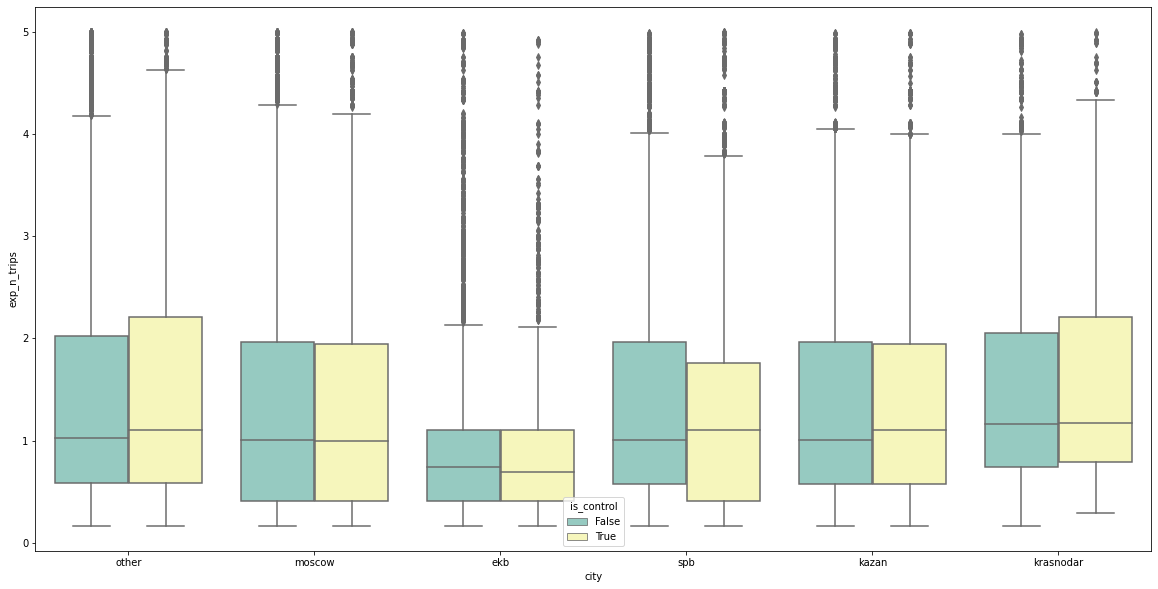

In [27]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x="city", y="exp_n_trips", hue="is_control", data=new_train_df, palette="Set3");

Информативный график получился.
- Во-первых, распределение на тестовую и контрольную группу -- хорошее, везде примерно одинаковые распределения по городам.
- Во-вторых, очень много людей не попадают в 0.75 квантиль, что логично т.к. есть постоянные пользователи Я.такси.
- В-третьих, в Екб в среднем на Яндекс такси ездят меньше, чем в других городах России. Стоит понять, почему  люди из Екб ездят редко всреднем (меньше 3 раз на человека за 56 дней), а в других больше 3 раз.

И да посмотрим, может быть где-то есть пропуски...

In [28]:
new_train_df.isna().any()

city_56_cat_distribution_ekb                           False
city_56_cat_distribution_kazan                         False
city_56_cat_distribution_kransnodar                    False
city_56_cat_distribution_moscow                        False
city_56_cat_distribution_others                        False
city_56_cat_distribution_spb                           False
discount_value_56_sum                                  False
duration_sec_56_sum_with_orders                        False
duration_sec_56_sum_wo_orders                          False
is_control                                             False
last_absent_days                                       False
last_absent_days_wo_sessions                           False
missed_days_orders_56_mean                             False
missed_days_sessions_56_mean                           False
offer_cnt_56_conversion_rate                           False
offer_cnt_56_sum_with_orders                           False
offer_cnt_56_sum_wo_orde

Стоило сделать это раньше, но мне повезло и пропусков нет. Так пришлось бы обучать catboost.

Сделаем трансформацию таргета.

$$Z_i = Y_i\frac{W_i - p_i}{p_i(1-p_i)}$$

In [29]:
p = new_train_df.is_control.sum() / new_train_df.shape[0]
print("Сейчас тест и контроль не по 0.5")
print("Отношения тестовой выборки к контрольной", 1 - p)

Сейчас тест и контроль не по 0.5
Отношения тестовой выборки к контрольной 0.807102919029767


То есть тестовых данных больше, чем контрольных, поэтому давайте обучим модель, которая будет предсказывать вероятность $p_i$, что семпл принадлежит тестовой выборки.

In [30]:
new_train_df.city = pd.factorize(new_train_df.city)[0]
cols = ["exp_n_trips", "exp_discount_value", "is_control"]
X = new_train_df.loc[:, ~new_train_df.columns.isin(cols)]
y = new_train_df.is_control.astype(int)



In [31]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=2000, learning_rate=0.01, depth=4)
model.fit(X, y, silent=True)

Сделаем трансформацию таргета.

In [38]:
p = model.predict_proba(X)[:, 1]
W = 1 - y
Y = new_train_df.exp_n_trips

Z = Y * (W - p) / (p * (1 - p))

In [39]:
Z.sum()

1337282.2075420287

Обучим еще один катбуст для регрессии.

In [40]:
cols = ["exp_n_trips", "exp_discount_value", "city"]
X = new_train_df.loc[:, ~new_train_df.columns.isin(cols)]
y = Z

In [48]:
from catboost import CatBoostRegressor
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=3000,
                          learning_rate=0.001,
                          depth=4)
# Fit model
model.fit(X, y, plot=True, silent=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [49]:
cols = ["exp_n_trips", "exp_discount_value"]

X_test = test_df.loc[:, ~test_df.columns.isin(cols)]

test_pred = model.predict(X_test)

In [50]:
test_pred

array([ 5.25501935,  4.51496519,  4.65380723, ...,  5.07876785,
       -0.83936343,  4.61914577])

In [51]:
cost = CostMetrics(pd.DataFrame({
    'Model': test_pred,
    'w': ~test_df.is_control.values,
    'exp_n_trips': test_df.exp_n_trips,
    'exp_discount_value': test_df.exp_discount_value
}))

In [52]:
cost.get_cumlift()

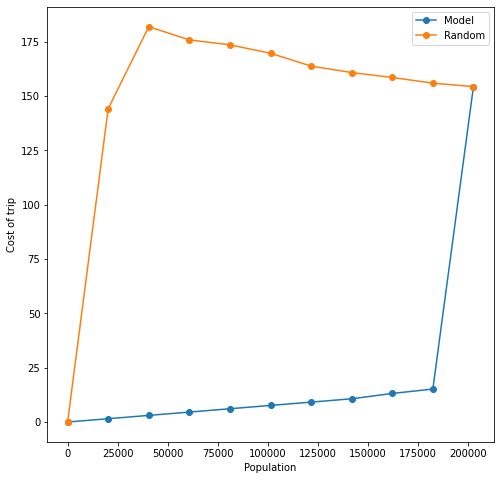

In [53]:
cost.plot()

In [54]:
cost.auuc_score()

Model       8.735273
Random    174.159396
dtype: float64

Видим, как хорошо у нас видна разница между контролем и тестом. Поэтому смело внедряем новую фичу.

### Задание 2

Предложите свой способ разбиения пользователей на 4 группы по uplift-скору.  
То есть нужно перейти от индивидуальных значений по скору к групповым.  
Обоснуйте свой выбор с помощью метрик и/или графиков.  

Мы можем кластеризовать данные и каждому кластеру присваивать метку, которая основывается на uplift-скор.

In [55]:
df = pd.DataFrame([test_df.is_control.astype(int), test_pred]).T

In [56]:
df.shape

(202893, 2)

In [57]:
from sklearn.cluster import KMeans

# create kmeans object
kmeans = KMeans(n_clusters=4)
# fit kmeans object to data
kmeans.fit(df)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(df)

[[-1.45522483e-13  4.90143283e+00]
 [ 1.00000000e+00 -1.08253960e+00]
 [-9.57567359e-15  1.08684544e+01]
 [-3.98847622e-14  7.22900727e+00]]


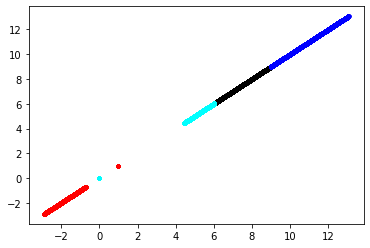

In [60]:
plt.scatter(df[y_km == 0], df[y_km == 0], s=10, c='red')
plt.scatter(df[y_km ==1], df[y_km == 1], s=10, c='black')
plt.scatter(df[y_km ==2], df[y_km == 2], s=10, c='blue')
plt.scatter(df[y_km ==3], df[y_km == 3], s=10, c='cyan')

Вполне понятно как кластеризовались пользователи.

### Задание 3 - творческое

Попробуйте придумать свой подход к оптимизации стоимости доп трипа.  
Скорее всего, это потребует выйти за рамки реализованных библиотек.  
Как возможные идеи: 
* подумать о новом критерии для сплита дерева, 
* изменить таргет для пользователя, 
* оптимизировать таргет на группе

Давайте начнем с нуля.
Наша задача как можно выгоднее внедрять новую фичу, которые мы протестировали на тестовой группе. 

Во-первых, мы можем использовать более сложные методы кластеризации. Например, umap

In [ ]:
import umap.umap_ as umap
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Scale
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X_test.copy())

manifold = umap.UMAP().fit(X, test_pred)

In [ ]:
import umap.plot

umap.plot.points(manifold, labels=y, theme="fire");

Видим, что данные локализованы в некоторых кластерах. С этими кластерами лучше работаь отдельно.

Во-вторых, в каждой группе отдельно будем считать разные таргеты. Например, если кластер характеризуется городом, то логично использовать таргет нацеленный на определенную местность.

В-третьих, в качестве итоговых решений неплохо бы проверить гипотезы, а затем применить МПГ, так мы можем интерпретировать нашу модель в отлоненных гипотезах.